# Lecture 2: the phase kickback trick

<center><img src="./figures/dall-e/merlion_kickback.png" alt="drawing" width="400"/></center>
<center><strong>Fig. 2:</strong> The merlion and the kickback [DALL-E].</center>

### Introduction

This is going to be a very short lecture, but still relevant to get familiar with one of the most simple and common tricks used in quantum computing: the phase kickback.
But before introducing and implementing an example of phase kickback, we should also introduce a very related topic: **ancilla qubits**.

The **ancilla** is typically an extra qubit of your system, which can be useful for many reasons.

<center><img src="./figures/ancillas.png" alt="drawing" width="600"/></center>

In a nutshell, the phase kickback is a process in which we apply a controlled operation on a target qubit using another qubit as control, but amazingly we get a modification only in the control qubit!

Let's start importing some useful objects.

In [114]:
import numpy as np

import qibo
from qibo import Circuit, gates

from scripts import plotscripts

from importlib import reload
reload(plotscripts)

<module 'scripts.plotscripts' from '/home/matteo/Documents/PhD/qclectures/scripts/plotscripts.py'>

In [115]:
qibo.set_backend("qibojit")

[Qibo 0.2.4|INFO|2024-01-24 12:52:44]: Using qibojit (numba) backend on /CPU:0


Let's consider two qubits: a first one is used as control, while a second is the target. An important requirement to exploit the phase kickback is that the second qubit's state is an eigenvector of the operator we aim to apply.

#### Phase kickback implementation

1. we initialize a two qubit circuit;
2. we apply an Hadamard gate to the first qubit, which will be the control one, and a Pauli X to the second qubit. This step will prepare the system into the state $$ |\psi_1\rangle = \frac{|01\rangle + |11\rangle}{\sqrt{2}}; $$
3. if the state vector of the target qubit $|q_{\rm t}\rangle$ is an eigenvector of the chosen gate, it satisfies $$ G|q_{\rm t}\rangle = \lambda_G\,|q_{\rm t}\rangle.$$
4. In our case we may consider the controlled version of a $G$ gate, which has $|1\rangle$ as eigenvector:  $$ |\psi_2\rangle = CG |\psi_1\rangle = \frac{|01\rangle + G|11\rangle}{\sqrt{2}} = 
\frac{|01\rangle + \lambda_{G}|11\rangle}{\sqrt{2}} = \frac{|0\rangle + \lambda_{G}|1\rangle}{\sqrt{2}} \times |1\rangle.$$

After step 4., the state of the control qubit has been changed, while the target one is untouched.

#### A practical case study

We consider the $T$ gate, which has the state $|1\rangle$ as eigenvector with eigenvalue $\lambda_G \neq 0$.

In [116]:
c = Circuit(2)
c.add(gates.H(0))
c.add(gates.X(1))

print(c(), "\n")
print(c.draw())

(0.70711+0j)|01> + (0.70711+0j)|11> 

q0: ─H─
q1: ─X─


In [117]:
c = Circuit(1)
c.add(gates.X(0))
c.add(gates.T(0))

print(c())

(0.70711+0.70711j)|1>


#### Full implementation

In [133]:
def execute_circuit(kickback=False):
    """Execute circuit with or without phase kickback."""
    c = Circuit(2)
    c.add(gates.X(1))
    c.add(gates.H(0))
    if kickback:
        c.add(gates.T(1).controlled_by(0))
    c.add(gates.H(0))
    c.add(gates.M(*range(2)))

    outcome = c(nshots=100)
    return outcome 

(1+0j)|01>


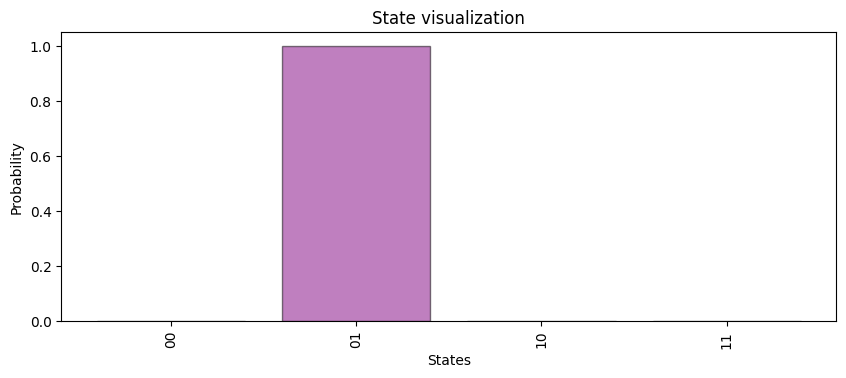

In [134]:
outcome = execute_circuit(kickback=False)
print(outcome)
plotscripts.plot_probabilities_from_state(outcome.state())

(0.85355+0.35355j)|01> + (0.14645-0.35355j)|11>


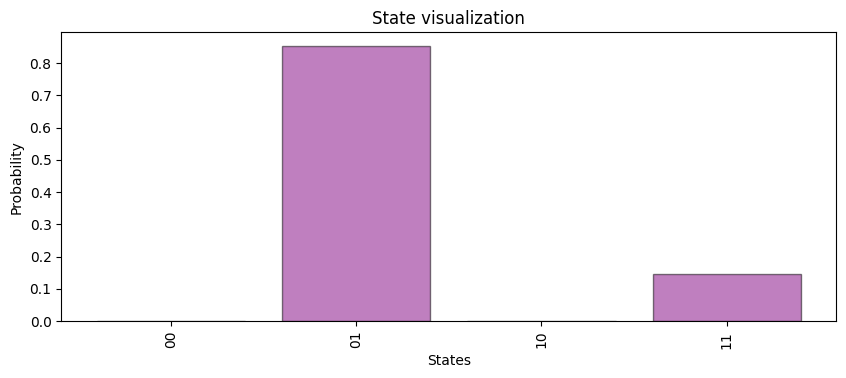

In [135]:
outcome = execute_circuit(kickback=True)
print(outcome)
plotscripts.plot_probabilities_from_state(outcome.state())

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> can you find a quantum gate $CG$ which applies a larger kickback effect then the $CT$ ? In other words, can you replace $CT$ in the previous circuit with a gate which reduces the $|01\rangle$ amplitude increasing the one of $|11\rangle$ ?
</div>

#### Let's complicate the example

We now add some more features to the example: we add the possibility to repeat the circuit architecture many times, in order to see what happens if we recursive manipulate the amplitude of the inpur register;

In [97]:
# adding recursion and keeping the superposition
def execute_circuit(kickback=False, ntimes=1):
    """Execute circuit with or without phase kickback."""
    c = Circuit(2)
    c.add(gates.X(1))

    for i in range(ntimes):
        c.add(gates.H(0))
        if kickback:
            c.add(gates.T(1).controlled_by(0))
        c.add(gates.H(0))
    c.add(gates.M(*range(2)))
    
    outcome = c(nshots=1000) 
    return outcome 